# Preprocessing the data

Function for loading the Dataset.

In [1]:
import numpy as np
from urllib.request import urlopen

def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_train), 784) 
                                                                                            
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_train, Y_train, X_test, Y_test

X_train_val, Y_train_val, X_test, Y_test = load_fashion_mnist()


First of all let's have a look of the data. The images are already in grey-scale since every pixel has just one number.

(60000, 784) (60000,) (10000, 784) (10000,)
Min: 0
Max: 255
Mean: 97.25383
Min: 0
Max: 255
Mean: 88.72704
Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


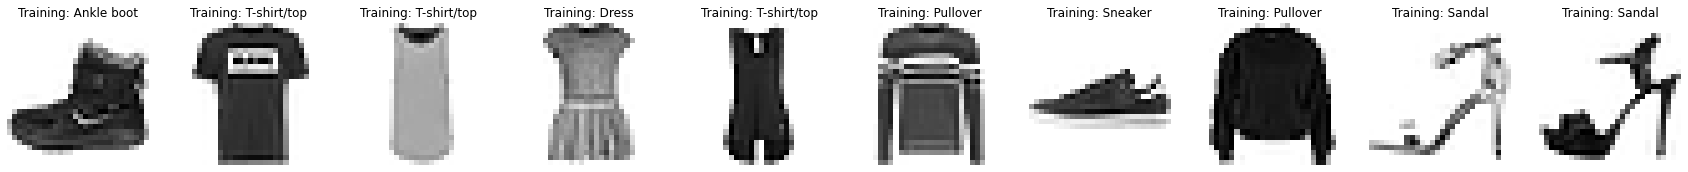

In [2]:
import matplotlib.pyplot as plt 
from collections import Counter

print(X_train_val.shape, Y_train_val.shape, X_test.shape, Y_test.shape) #shape of the data
#value of the data
print(f"Min: {X_train_val[0].min()}")
print(f"Max: {X_train_val[0].max()}")
print(f"Mean: {X_train_val[0].mean():.5f}")
print(f"Min: {X_train_val[10].min()}")
print(f"Max: {X_train_val[10].max()}")
print(f"Mean: {X_train_val[10].mean():.5f}")
#grayscale goes from 0 to 255

#what are our images
labels_name={
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot'
}

print(Counter(Y_train_val)) #classes are perfectly balanced

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 9)) #data displayed
for ax, x, label in zip(axes,X_train_val[0:10], Y_train_val[0:10]):
  ax.set_axis_off()
  X_image=x.reshape(28,28)
  ax.imshow(X_image, cmap=plt.cm.gray_r, interpolation="nearest")
  ax.set_title("Training: %s" % labels_name[label])

Data are perfectly balanced, so far as I know I won't need Under or Over Sampling methods.

I build the validation and the training set.

In [3]:
from sklearn.model_selection import train_test_split
# we prefer a small validation set since dataset is quite big
X_train, X_val, y_train, y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, shuffle=False)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(Counter(y_train))
#data are still balanced

(54000, 784) (54000,) (6000, 784) (6000,)
Counter({7: 5445, 6: 5435, 1: 5416, 5: 5409, 2: 5398, 3: 5395, 8: 5384, 9: 5381, 0: 5370, 4: 5367})


Now we build a data set with a smaller size to easly implement grid search for our classifiers.

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#training and validation sets rescaled in 0-1 values 
minmax_scal=MinMaxScaler().fit(X_train_val)
X_train_mm=minmax_scal.transform(X_train)
X_val_mm=minmax_scal.transform(X_val)
# this means X_train_mm=X_train/255

#training and validation sets rescaled with 0 mean 1 std
stand_scal=StandardScaler().fit(X_train_val)
X_train_ss=stand_scal.transform(X_train)
X_val_ss=stand_scal.transform(X_val)


In [5]:
#smaller data sets
X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(X_val, y_val, test_size=0.1, shuffle=False)
print(X_train_small.shape, y_train_small.shape, X_val_small.shape, y_val_small.shape)
print(Counter(y_train_small))

#data more or less balanced

(5400, 784) (5400,) (600, 784) (600,)
Counter({0: 570, 9: 564, 4: 562, 3: 553, 8: 550, 2: 535, 5: 532, 1: 520, 6: 516, 7: 498})


Let's start to implement the classifiers.

For this classification task there's no reason to prefer a false positive to a false negative. We evaluate the performance of all the classifier by the accuracy on the validation set prediction.
The best accuracy score on validation set for classifier is reported in the title of each paragraph.

# 3) Support Vector Machine. (0.89350)

SVM can run only with small data set, training on the all data takes 3 minutes and make a prediction on the training set takes 14 minutes. For this reason we prefer to avoid to make a prediction for the training set, computing the accuracy score only for the validation set. (Uncomment the cell of the training set to see its accuracy score)

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#parameters
svc_grid_params = {
    'C': ( 1, 10, 100),
    'kernel': ('rbf', 'linear'),
}

#grid search object
model = svm.SVC(random_state = 123)
clf_4 = GridSearchCV(estimator = model,
                     param_grid = svc_grid_params, 
                     scoring='accuracy',
                     n_jobs= -1, cv = 5, verbose = 1)

#training 
clf_4.fit(X_train_small,y_train_small)


print(clf_4.best_params_)
print(clf_4.best_score_)

#expected output:
#Fitting 5 folds for each of 6 candidates, totalling 30 fits
#{'C': 100, 'kernel': 'rbf'}
#0.8585185185185186

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'C': 100, 'kernel': 'rbf'}
0.8585185185185186


In [7]:
#model definition with best parameters
clf_svm=svm.SVC(random_state = 123,
                kernel = 'rbf',
                C=100)

#training 
clf_svm.fit(X_train,y_train)

#make a prediction for the validation set
y_pred_svm_val=clf_svm.predict(X_val) 
print(f"accuracy score SVM on validation set: \t{accuracy_score(y_val,y_pred_svm_val):.5f}")

#expected output:
#accuracy score SVM on validation set: 	0.89183

accuracy score SVM on validation set: 	0.89183


In [ ]:
"""
y_pred_svm_train=clf_svm.predict(X_train) 
print(f"accuracy score SVM on trainin set: \t{accuracy_score(y_train,y_pred_svm_train):.5f}")
"""

#expected output
#accuracy score SVM on trainin set: 	0.99969

'\ny_pred_svm_train=clf_svm.predict(X_train) \nprint(f"accuracy score SVM on trainin set: \t{accuracy_score(y_train,y_pred_svm_train):.5f}")\n'

# 4) Artificial Neural Network. (0.89417)

In Keras documentation we can read that "images need to be read and decoded into integer tensors, then converted to floating point and normalized to small values (usually between 0 and 1)".

For this reason in the ANN implementation we use data preprocessed by Standard Scaler.

First of all I implement a function that allows me to make e grid search for the optimal parameters.

In [11]:
#libraries I need
import tensorflow
import numpy as np
import tensorflow 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#function for define and train more NN
def MLP(X,y,vector_units,n_epochs,stop,n_patience):
    #X already scaled
    #y not transformed by to_categorical
    
    #processing data
    features=np.shape(X)[1] #the input size
    num_classes=len(set(y))
    np.random.seed(123)
    set_random_seed(2)

    model=Sequential()
    n_layers=len(vector_units) #we consider only the hidden layer
    if n_layers==0:
      model.add(Dense(input_dim=features, 
                      units = num_classes, 
                      activation= 'softmax'))
    else:
      for i in range(n_layers):
        if i==0:
          model.add(Dense(input_dim=features,
                          units=vector_units[0],
                          activation='relu'))
        else: 
          model.add(Dense(units=vector_units[i],
                          activation='relu'))
      model.add(Dense(units = num_classes, 
                      activation= 'softmax'))
    
    #configure the model
    model.compile(loss='categorical_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy']) 
    
    #EarlyStopping
    if stop=='True':
      stop_er=EarlyStopping(monitor='val_loss', #quantity to be monitored
                    mode='min', #we look for decreasing patterns stop 
                    patience = n_patience, #number of epochs with no improvements
                    verbose=1)
    else:
      stop_er=None
    #training
    y=to_categorical(y,num_classes)
    train=model.fit(X,y,epochs=n_epochs,
                    batch_size=32, 
                    verbose=0,
                    validation_split=0.1,
                    callbacks=stop_er)
    
    return model,train

I create two smaller data sets of scaled data and the one-hot encoding of the labels.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#smaller data set for the grid search
minmax_scal=MinMaxScaler().fit(X_train_small)
X_train_mms=minmax_scal.transform(X_train_small) 
X_val_mms=minmax_scal.transform(X_val_small) 

#second smaller dataset for a comparison
standard_scal=StandardScaler().fit(X_train_small)
X_train_sss=standard_scal.transform(X_train_small) 
X_val_sss=standard_scal.transform(X_val_small) 

#one hot encoding
y_train_cs=to_categorical(y_train_small,10)
y_val_cs=to_categorical(y_val_small,10)


Now I can train several NN to find the best parameters.
Even though I used smaller data set this cell requires 15 or more minutes to run. Since this is actually the best model among the others it's worth it.

Epoch 00032: early stopping
0
Epoch 00081: early stopping
1
2
Epoch 00037: early stopping
3
Epoch 00083: early stopping
4
Epoch 00093: early stopping
5
Epoch 00032: early stopping
6
Epoch 00081: early stopping
7
Epoch 00119: early stopping
8
Epoch 00037: early stopping
9
Epoch 00083: early stopping
10
Epoch 00093: early stopping
11




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
best parameters:  [[784], 100, 15]


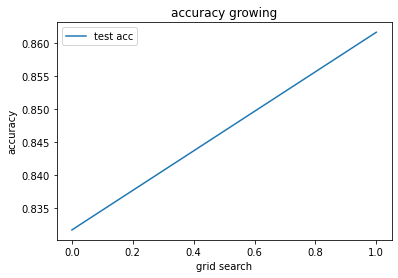

In [ ]:
#parameters of the function

#to avoid a 50 minutes run I put a shortes version of vector_units_list but the results is the same
# vector_units_list=[[784],[784,10],[500,200],[784,100,50],[784,200,50,10]] #long research
vector_units_list=[[784],[784,10]]
n_epochs_list=[100,500]
n_patience_list=[5,15,25]
stop='True'
#let save the maximum accuracy
acc=0
accuracy_test=[]
i=0
#grid-search
for n_epochs in n_epochs_list:
  for vector in vector_units_list:
    for n_patience in n_patience_list:

      #train a NN 
      m,t=MLP(X_train_mms,y_train_small,vector,n_epochs,stop,n_patience)
      print(i)
      i+=1
      #save the greater accuracy
      accuracy_val=m.evaluate(X_val_mms,y_val_cs,verbose=0)[1]
      if accuracy_val>acc:
        acc=accuracy_val
        win=[vector,n_epochs,n_patience]
        model=m
        accuracy_test.append(accuracy_val)

print('\n\n\n')
print(model.summary())
print('best parameters: ',win)
plt.plot(accuracy_test)
plt.title(f"accuracy growing")
plt.ylabel('accuracy')
plt.xlabel('grid search')
plt.legend(['test acc'], loc='upper left')
plt.show()

#expected output:
# best parameters: [[784], 100, 15]

Now I can train on the whole batch of data one Artificial Neural Network with the best parameters found.

In [ ]:
#runtime= ~10 minutes

#early stopping
stop=EarlyStopping(monitor='val_loss', #quantity to be monitored
                    mode='min', #we look for decreasing patterns stop 
                    patience = 15, #number of epochs with no improvements
                    verbose = 1)
#data
features=np.shape(X_train)[1]
num_classes=10 
y_train_cat=to_categorical(y_train,num_classes)
y_val_cat=to_categorical(y_val,num_classes)


#model defining
np.random.seed(123)
set_random_seed=2

nn=Sequential()
nn.add(Dense(input_dim=features,
             units=features,
             activation='relu'))
nn.add(Dense(num_classes,
             activation='softmax'))
print(nn.summary())

#compiling and training
nn.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])
train=nn.fit(X_train_mm,y_train_cat,
             batch_size=32,
             verbose=0,
             callbacks=stop,
             epochs=100,
             validation_split=0.1)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 784)               615440    
                                                                 
 dense_31 (Dense)            (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00085: early stopping


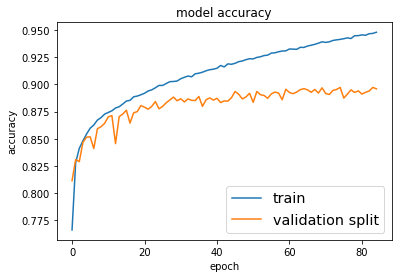

minmax
acc on train set: 0.94652, acc on validation set:0.89350


In [ ]:
#display the accuracy 
plt.plot(train.history['accuracy'])
plt.plot(train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation split'],loc='down right',fontsize='x-large')
plt.show()

#make prediction on training and validation set
y_pred_nn_train=nn.predict(X_train_mm).argmax(axis = 1) 
y_pred_nn_val=nn.predict(X_val_mm).argmax(axis = 1) 
print('minmax')
print(f'acc on train set: {accuracy_score(y_train,y_pred_nn_train):.5f}, acc on validation set:{accuracy_score(y_val,y_pred_nn_val):.5f}')


#expected output:
#minmax
#acc on train set: 0.94765, acc on validation set:0.89083


## What happen with Standard Scaler?

Now I another ANN using the data preprocessed by the standard scaler. The accuracy score reached on the validation is a little better then the one reached before.

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 784)               615440    
                                                                 
 dense_33 (Dense)            (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00024: early stopping


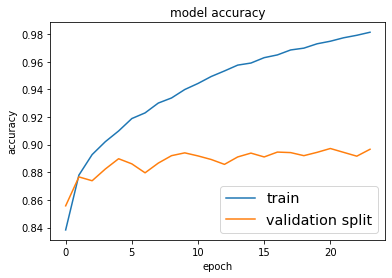

Standard Scaler
acc on train set: 0.97707, acc on validation set:0.89550


In [ ]:
#early stopping
stop=EarlyStopping(monitor='val_loss', #quantity to be monitored
                    mode='min', #we look for decreasing patterns stop 
                    patience = 15, #number of epochs with no improvements
                    verbose = 1)

#model defining
np.random.seed(123)
set_random_seed=2

nns=Sequential()
nns.add(Dense(input_dim=features,
             units=features,
             activation='relu'))
nns.add(Dense(num_classes,
             activation='softmax'))
print(nns.summary())

#compiling and training
nns.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])
train_s=nns.fit(X_train_ss,y_train_cat,
             batch_size=16,
             verbose=0,
             callbacks=stop,
             epochs=100,
             validation_split=0.1)


#display the accuracy 
plt.plot(train_s.history['accuracy'])
plt.plot(train_s.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation split'],loc='down right',fontsize='x-large')
plt.show()

#make prediction on training and validation set
y_pred_train_ss=nns.predict(X_train_ss).argmax(axis = 1) 
y_pred_val_ss=nns.predict(X_val_ss).argmax(axis = 1) 
print('Standard Scaler')
print(f'acc on train set: {accuracy_score(y_train,y_pred_train_ss):.5f}, acc on validation set:{accuracy_score(y_val,y_pred_val_ss):.5f}')


#expected output:
#Standard Scaler
#acc on train set: 0.97587, acc on validation set:0.89417

#5) K-Nearest Neighbors Classifier. (0.85850)

I implement a K-NN algorithm for the smaller data set, searching for the optimal value of K by measuring the accuracy score.

In [ ]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier

train_accuracy = []
val_accuracy = []

k_values = [2,4,6,8,10,12,14,18,22,30,40,50] 

for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train_small, y_train_small)
  y_pred_train = model.predict(X_train_small)
  y_pred_val = model.predict(X_val_small)
  train_accuracy.append(accuracy_score(y_train_small, y_pred_train))
  val_accuracy.append(accuracy_score(y_val_small,y_pred_val))

We display the accuracy scores for train and validation set to find the best K-value.

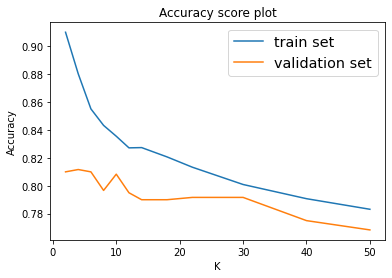

In [ ]:
#accuracy

plt.plot(k_values, train_accuracy)
plt.plot(k_values, val_accuracy)
plt.xlabel("K")
plt.ylabel("Accuracy")  
plt.title('Accuracy score plot')
plt.legend(['train set','validation set'],loc='upper right',fontsize='x-large')
plt.show()


K=4 seem to be a little better than the other values.


In [ ]:
#runtime= 4 min 28''

#model
model = KNeighborsClassifier(n_neighbors=4)

#training
model.fit(X_train, y_train)

#make prediction
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
print(f"accuracy score on train:{accuracy_score(y_train,y_pred_train):.5f},accuracy score on validation:{accuracy_score(y_val,y_pred_val):.5f}")


#expected output:
#accuracy score on train:0.90702,accuracy score on validation:0.85850

accuracy score on train:0.90702,accuracy score on validation:0.85850


## What happen with scaled data?

I compute the accuracy score only for the small validation set.
The results don't change a lot.

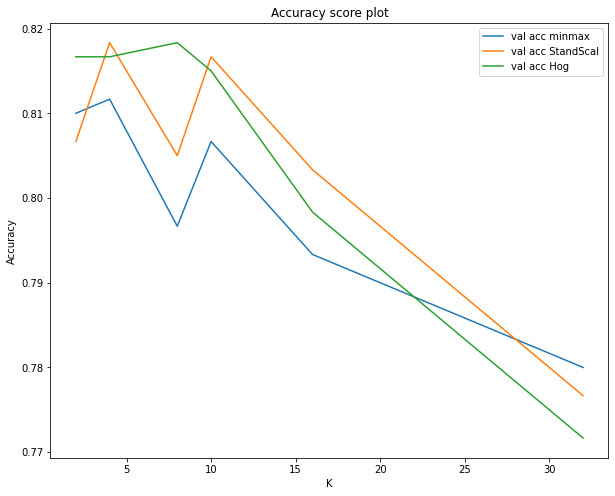

Minmax scaled data
accuracy score on train:0.907, on validation:0.85833
Standard scaled data
accuracy score on train:0.9093, on validation:0.85750
HOG transformed data
accuracy score on train:0.8813, on validation:0.81667


In [ ]:
#k values tested
k_values= [2,4,8,10,16,32] 


#minmax scaler data
val_accuracy_mm = []

for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train_mms, y_train_small)
  y_pred_val = model.predict(X_val_mms)
  val_accuracy_mm.append(accuracy_score(y_val_small,y_pred_val))



#standard scaler data
val_accuracy_ss=[]

for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train_sss, y_train_small)
  y_pred_val_sss = model.predict(X_val_sss)
  val_accuracy_ss.append(accuracy_score(y_val_small,y_pred_val_sss))



#hog trnasformed data
val_accuracy_hog = []

for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train_hog, y_train_small)
  y_pred_val_hog = model.predict(X_val_hog)
  val_accuracy_hog.append(accuracy_score(y_val_small,y_pred_val_hog))



#accuracy on the small validation set
fig = plt.figure(figsize=(10,8))
plt.plot(k_values, val_accuracy_mm, label="val acc minmax")
plt.plot(k_values, val_accuracy_ss, label="val acc StandScal")
plt.plot(k_values, val_accuracy_hog, label="val acc Hog")
plt.xlabel("K")
plt.ylabel("Accuracy")  
plt.title('Accuracy score plot')
plt.legend()
plt.show()



model_mm = KNeighborsClassifier(n_neighbors=4)
model_mm.fit(X_train_mm, y_train)
y_pred_train_mm = model_mm.predict(X_train_mm)
y_pred_val_mm = model_mm.predict(X_val_mm)
print('Minmax scaled data')
print(f"accuracy score on train:{accuracy_score(y_train,y_pred_train_mm):.5}, on validation:{accuracy_score(y_val,y_pred_val_mm):.5f}")

model_ss = KNeighborsClassifier(n_neighbors=4)
model_ss.fit(X_train_ss, y_train)
y_pred_train_ss = model_ss.predict(X_train_ss)
y_pred_val_ss = model_ss.predict(X_val_ss)
print('Standard scaled data')
print(f"accuracy score on train:{accuracy_score(y_train,y_pred_train_ss):.5}, on validation:{accuracy_score(y_val,y_pred_val_ss):.5f}")

model_hog = KNeighborsClassifier(n_neighbors=4)
model_hog.fit(X_train_hog, y_train_small)
y_pred_train_hog = model_hog.predict(X_train_hog)
y_pred_val_hog = model_hog.predict(X_val_hog)
print('HOG transformed data')
print(f"accuracy score on train:{accuracy_score(y_train_small,y_pred_train_hog):.5}, on validation:{accuracy_score(y_val_small,y_pred_val_hog):.5f}")


#expected output:
#Minmax scaled data
#accuracy score on train:0.907, on validation:0.85833
#Standard scaled data
#accuracy score on train:0.9093, on validation:0.85750
#HOG transformed data
#accuracy score on train:0.8813, on validation:0.81667

# Conclusion

I can finally watch the performance on the test set using the best model found: the artificial neural network (wich works a little better then the SVM). 
Before this I only need to preprocess the Test Set using MinMax Scaler.

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 784)               615440    
                                                                 
 dense_37 (Dense)            (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00060: early stopping


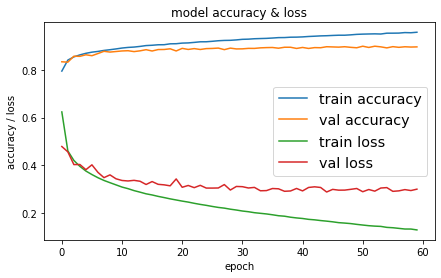

Accuracy
test set: 0.89000


In [ ]:
#run time of final cell: 10minutes more or less

import tensorflow
import numpy as np
import tensorflow 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

#preprocessing
X_train_val_mm=X_train_val/255
X_test_mm=X_test/255
y_train_val_cat=to_categorical(Y_train_val,10)

#early stopping
stop=EarlyStopping(monitor='val_loss', #quantity to be monitored
                    mode='min', #we look for decreasing patterns stop 
                    patience = 15, #number of epochs with no improvements
                    verbose = 1)

#model defining
np.random.seed(123)
set_random_seed=2

nn_final=Sequential()
nn_final.add(Dense(input_dim=features,
             units=features,
             activation='relu'))
nn_final.add(Dense(num_classes,
             activation='softmax'))
print(nn_final.summary())

#compiling and training
nn_final.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])
train_final=nn_final.fit(X_train_val_mm,y_train_val_cat,
             batch_size=16,
             verbose=0,
             callbacks=stop,
             epochs=100,
             validation_split=0.1)


#display the accuracy and the loss
fig = plt.figure(figsize=(7,4))
plt.plot(train_final.history['accuracy'])
plt.plot(train_final.history['val_accuracy'])
plt.plot(train_final.history['loss'])
plt.plot(train_final.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train accuracy','val accuracy','train loss','val loss'],loc='down right',fontsize='x-large')
plt.show()


#make prediction on training and validation set
y_pred_test_final=nn_final.predict(X_test_mm).argmax(axis = 1) 
print('Accuracy')
print(f'test set: {accuracy_score(Y_test,y_pred_test_final):.5f}')


#expected output:
#Accuracy
#test set: 0.89100

The total run time of the notebook is 1 hour and 30 minutes